In [1]:
import os
import torch
import torchvision
import torchmetrics
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader

/home/wiratama/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
import shutil
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' has been deleted successfully.")
    else:
        print(f"Folder '{folder_path}' does not exist or is not a directory.")

# Contoh penggunaan
folder_path = 'generated_images_9'

delete_folder(folder_path)


Folder 'generated_images_9' has been deleted successfully.


In [3]:
metadata_frame = pd.read_csv("./skin-cancer/HAM10000_metadata.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABEL_ENCODING = {
    "nv": 0,
    "mel": 1,
    "bkl": 2,
    "bcc": 3,
    "akiec": 4,
    "vasc": 5,
    "df": 6
}

In [4]:
DATASET_PATH = "./skin-cancer/HAM10000_images"

dataset_list = []

for image in metadata_frame.to_dict(orient="records"):
    filename, y = image["image_id"], image["dx"]

    x_path = f"{DATASET_PATH}/{filename}.jpg"

    dataset_list.append((x_path, y))

dataset_list = np.random.permutation(dataset_list)
dataset_list[:8]

array([['./skin-cancer/HAM10000_images/ISIC_0028550.jpg', 'bkl'],
       ['./skin-cancer/HAM10000_images/ISIC_0031955.jpg', 'vasc'],
       ['./skin-cancer/HAM10000_images/ISIC_0033509.jpg', 'bkl'],
       ['./skin-cancer/HAM10000_images/ISIC_0032751.jpg', 'mel'],
       ['./skin-cancer/HAM10000_images/ISIC_0029076.jpg', 'nv'],
       ['./skin-cancer/HAM10000_images/ISIC_0026375.jpg', 'nv'],
       ['./skin-cancer/HAM10000_images/ISIC_0033584.jpg', 'nv'],
       ['./skin-cancer/HAM10000_images/ISIC_0030228.jpg', 'nv']],
      dtype='<U46')

In [5]:
class CustomDataset(Dataset):
    def __init__(
            self,
            dataset,
            encoding: dict,
            loader_transformer=None,
            augmented_transformer=None
    ):
        dataset = np.random.permutation(dataset)

        self.loader_transformer = loader_transformer
        self.augmented_transformer = augmented_transformer

        self.x = []
        self.y = []

        for x_path, y in dataset:
            image = Image.open(x_path)

            if loader_transformer:
                image = loader_transformer(image)

            self.x.append(image)
            self.y.append(encoding[y])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.augmented_transformer(self.x[idx]), self.y[idx]


loader_transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

augmented_transformer = transforms.Compose([
])

dataset = CustomDataset(
    dataset=dataset_list[:512],
    encoding=LABEL_ENCODING,
    loader_transformer=loader_transformer,
    augmented_transformer=augmented_transformer
)

In [6]:
def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))

    for i, ax in enumerate(axes.flat):
        _image = images[i].permute(1, 2, 0).cpu().numpy()
        _image = np.clip((_image + 1) / 2, 0, 1)

        ax.imshow(_image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

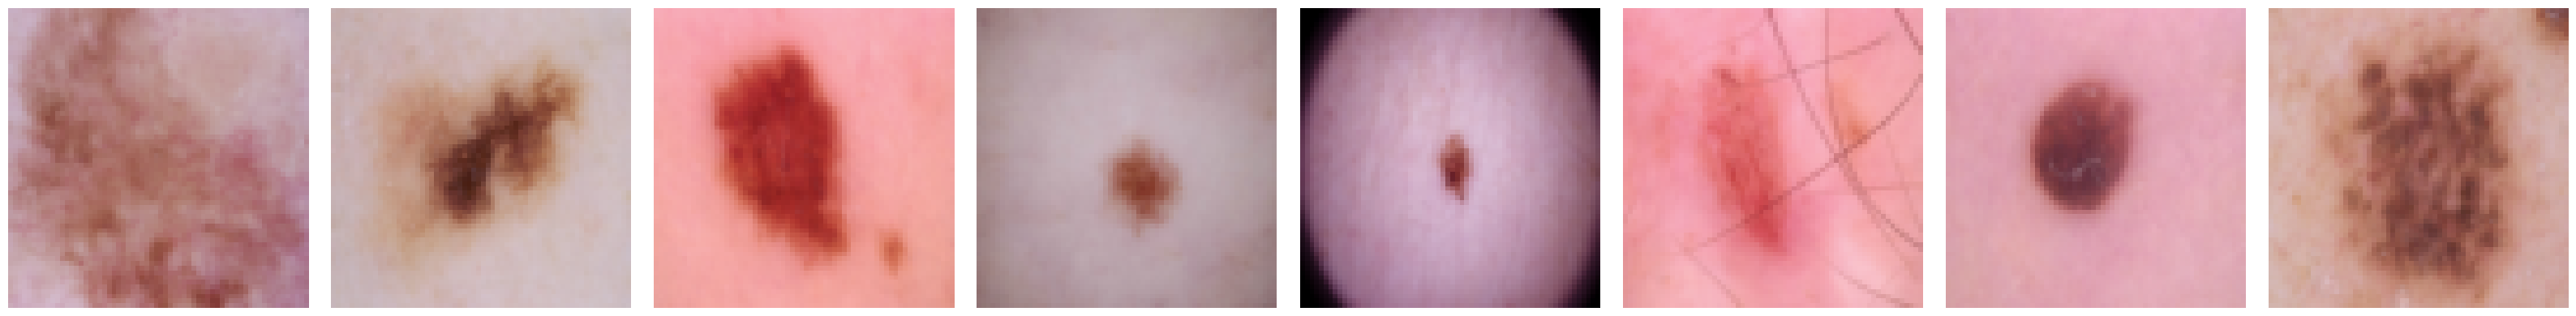

In [7]:
N_SAMPLES = 8

x_sample = torch.stack([dataset[i][0] for i in range(N_SAMPLES)])
y_sample = torch.tensor([dataset[i][1] for i in range(N_SAMPLES)], dtype=torch.long)

x_sample = x_sample.to(device)

plot_images(x_sample)

In [7]:
x_sample.shape

torch.Size([8, 3, 64, 64])

In [8]:
batch_size = 128

image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
import os
from torchvision.utils import save_image
import pandas as pd

# Create directory to save generated images
gen_images_dir = "generated_images_10"
os.makedirs(gen_images_dir, exist_ok=True)

# Create a list to store the metadata of generated images
generated_metadata = []

G_losses = []
D_losses = []
iters = 0

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Starting Training Loop...")
# For each epoch
for epoch in range(100):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save generated images with filenames based on epoch and batch indices
        for j in range(b_size):
            fake_img_name = f"epoch{epoch}_batch{i}_img{j}_generated.png"
            fake_img_path = os.path.join(gen_images_dir, fake_img_name)
            save_image(fake[j], fake_img_path)
            
            # Assuming the label for the generated images is the same as the real images' label
            # Adjust this part according to your actual label logic
            generated_metadata.append({"image_id": fake_img_name, "dx": "generated_label"})

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end="\r")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

# Save the generated metadata to a CSV file
gen_metadata_df = pd.DataFrame(generated_metadata)
gen_metadata_df.to_csv(os.path.join(gen_images_dir, "generated_metadata.csv"), index=False)

Starting Training Loop...


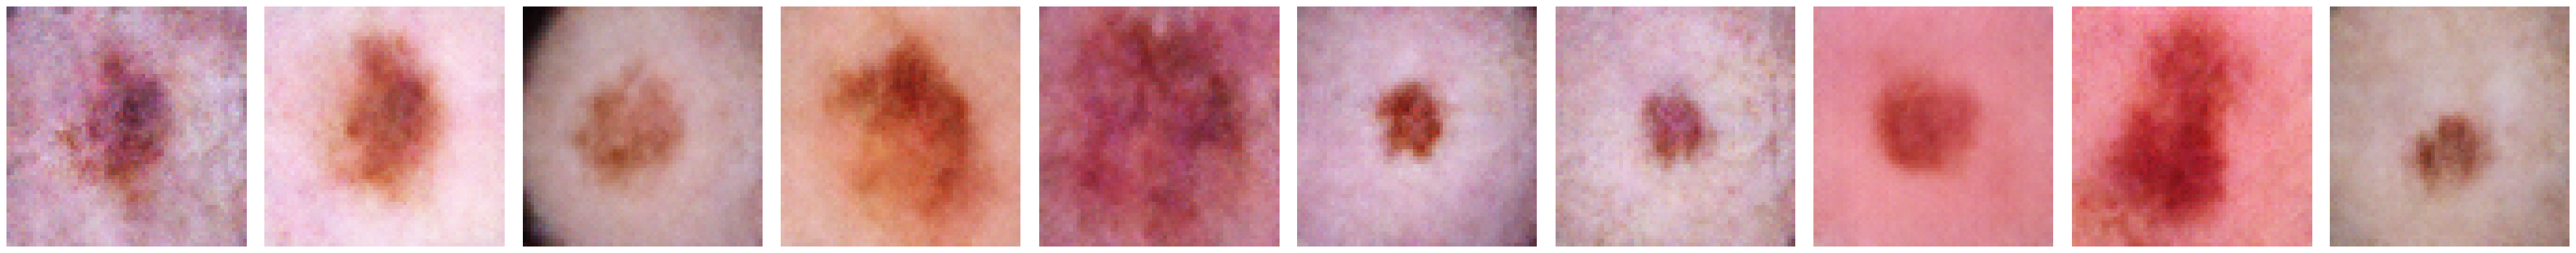

In [26]:
gen_imgs = netG(fixed_noise[:10])
plot_images(gen_imgs.detach())

In [39]:
import os
import shutil

def copy_files(src_folder, dest_folder):
    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Copy all files from the source folder to the destination folder
    for item in os.listdir(src_folder):
        src_path = os.path.join(src_folder, item)
        dest_path = os.path.join(dest_folder, item)

        if os.path.isdir(src_path):
            shutil.copytree(src_path, dest_path)
        else:
            shutil.copy2(src_path, dest_path)

def main():
    original_dataset_folder = DATASET_PATH
    generated_images_folder = 'generated_images_10'
    classification_folder = 'Classification'
    csv_file = './skin-cancer/HAM10000_metadata.csv'  # Assuming the CSV file is named 'labels.csv'

    # Step 1: Copy the original dataset to the classification folder
    copy_files(original_dataset_folder, classification_folder)

    # Step 2: Copy the generated images to the classification folder
    copy_files(generated_images_folder, classification_folder)

    # Step 3: Copy the CSV file to the classification folder
    shutil.copy2(csv_file, classification_folder)

    print("All files have been copied successfully.")

if __name__ == '__main__':
    main()


All files have been copied successfully.


In [41]:
import shutil
import os

def zip_folder(folder_path, output_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.make_archive(output_path, 'zip', folder_path)
        print(f"Folder '{folder_path}' has been zipped successfully into '{output_path}.zip'.")
    else:
        print(f"Folder '{folder_path}' does not exist or is not a directory.")

# Contoh penggunaan
folder_path = 'generated_images_10'
output_path = 'generated_images_10'  # Jangan sertakan ekstensi .zip, akan ditambahkan otomatis
zip_folder(folder_path, output_path)


Folder 'generated_images_10' has been zipped successfully into 'generated_images_10.zip'.


In [ ]:
DATASET_PATH_Classification = "./Classification"
METADATA_PATH_Classification = "./Classification/HAM10000_metadata.csv"


dataset_list = []

for image in metadata_frame.to_dict(orient="records"):
    filename, y = image["image_id"], image["dx"]

    x_path = f"{DATASET_PATH}/{filename}.jpg"

    dataset_list.append((x_path, y))

dataset_list = np.random.permutation(dataset_list)
dataset_list[:8]

In [ ]:
import shutil
import os

def delete_folder(folder_path):
    try:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted successfully.")
        else:
            print(f"Folder '{folder_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred while deleting the folder: {e}")

# Example usage
folder_path = './Classification'
delete_folder(folder_path)


In [ ]:
import os

# Define the path where you want to create the folder
folder_path = './Classification'

# Check if the folder already exists
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)
    print(f"Folder 'Train' created successfully at {folder_path}.")
else:
    print(f"Folder 'Train' already exists at {folder_path}.")


In [ ]:
import pandas as pd
metadata_frame.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
print("Unique Cancer types represented in data.")
print(meta_data.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
meta_data["dx_label"] = encoder.fit_transform(meta_data["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

In [ ]:
import shutil
import os

# Ensure `encoder` and `meta_data` are properly defined
# encoder = ... (Initialize encoder)
# meta_data = ... (Initialize meta_data with columns 'dx_label' and 'image_id')

# Sorting images into appropriate directories in order
# to facilitate real-time data augmentation while training.

# Using the cancer type label for directory creation.
dir_names = encoder.transform(encoder.classes_)

# Data Sorting process.
real_images_dir = r"./skin_cancer/HAM10000_images"
generated_images_dir = r"./gen_images"
train_images_dir = r"./Classification"

def create_dirs(dir_path: str, dir_names: list):
    """
    This function creates directories within specified directory path
    with the provided list of directory names.

    Inputs:
        dir_path: str - The path to which the new directories will reside in.
        dir_names: list - List name(s) of directories to be created.
    """
    # Looping through to create directories in new location.
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue

# Creating new directories.
create_dirs(train_images_dir, dir_names)

# Looping through each image in previous folder and
# assigning them to the appropriate folder
for image in os.scandir(images_dir):
    try:
        # Attempting to rename image (moving to new dir).
        img_name = image.name.split(".")[0].strip()

        # Print debug information
        print(f"Processing image: {img_name}")

        # Check if img_name exists in meta_data.image_id
        img_cancer_type_array = meta_data.dx_label[meta_data.image_id.str.strip() == img_name]

        if img_cancer_type_array.empty:
            print(f"No label found for image: {img_name}")
            continue

        if len(img_cancer_type_array) > 1:
            print(f"Multiple labels found for image: {img_name}")
            continue

        img_cancer_type = str(img_cancer_type_array.item())  # Retrieving the dx_label for image.
        dest_dir = os.path.join(train_images_dir, img_cancer_type)

        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        shutil.copy(os.path.join(images_dir, image.name), os.path.join(dest_dir, image.name))
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")


In [ ]:
from torch.cuda.amp import GradScaler, autocast

# Hyperparameters
NOISE_DIM = 100
CLASS_DIM = 1
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()

scaler_G = GradScaler()
scaler_D = GradScaler()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Create some fixed noise and labels to monitor progress during training
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)
fixed_labels = torch.randint(0, CLASS_DIM, (BATCH_SIZE,), device=DEVICE)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

global_step = 0

for epoch in range(NUM_EPOCHS):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs, labels = real_imgs.to(DEVICE), labels.to(DEVICE)

        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # with autocast():
        real_validity = discriminator(real_imgs)
        real_loss = criterion_GAN(real_validity, torch.ones(batch_size, 1, device=DEVICE))

        noise = torch.randn(batch_size, NOISE_DIM, device=DEVICE)
        gen_labels = torch.randint(0, CLASS_DIM, (batch_size,), device=DEVICE)

        fake_imgs = generator(noise)

        fake_validity = discriminator(fake_imgs.detach())
        fake_loss = criterion_GAN(fake_validity, torch.zeros(batch_size, 1, device=DEVICE))

        d_loss = (real_loss + fake_loss) / 2

        # scaler_D.scale(d_loss).backward()
        # scaler_D.step(optimizer_D)
        # scaler_D.update()

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # with autocast():
        fake_validity = discriminator(fake_imgs)
        g_loss = criterion_GAN(fake_validity, torch.ones(batch_size, 1, device=DEVICE))

        # scaler_G.scale(g_loss).backward()
        # scaler_G.step(optimizer_G)
        # scaler_G.update()

        g_loss.backward()
        optimizer_G.step()

        print(f"Step: {global_step}, G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}", end="\r")

        global_step += 1

        if global_step % 100 == 0:
            print(f"Step: {global_step}, G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}")

            gen_imgs = generator(fixed_noise[:6])
            plot_images(gen_imgs.detach())

print("Training complete.")

In [ ]:
gen_imgs = generator(fixed_noise[:6], fixed_labels[:6])
plot_images(gen_imgs.detach())

In [ ]:
torch.save(autoencoder.state_dict(), "./autoencoder_model.pth")

In [ ]:
_latent[0, 0].unsqueeze(0).shape

In [ ]:
_sample = _latent[0].sum(axis=1).unsqueeze(0)
_sample.shape
# plot_images([_sample, _sample])

In [ ]:
_latent = autoencoder.encoder(x).detach().cpu()

plot_images([_latent[0, x].unsqueeze(0) for x in range(8)])
plot_images([_latent[0, 8 + x].unsqueeze(0) for x in range(8)])

In [ ]:
latent = autoencoder.encoder(x)
latent.shape

In [ ]:
_x = autoencoder.decoder(latent, y)
__x = autoencoder.decoder(latent, torch.zeros_like(y))

plot_images(x[:8].detach().to(torch.float32))
plot_images(_x[:8].detach().to(torch.float32))
plot_images(__x[:8].detach().to(torch.float32))